In [1]:
import warnings

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp

from scipy.special import expit as logistic

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 12.1

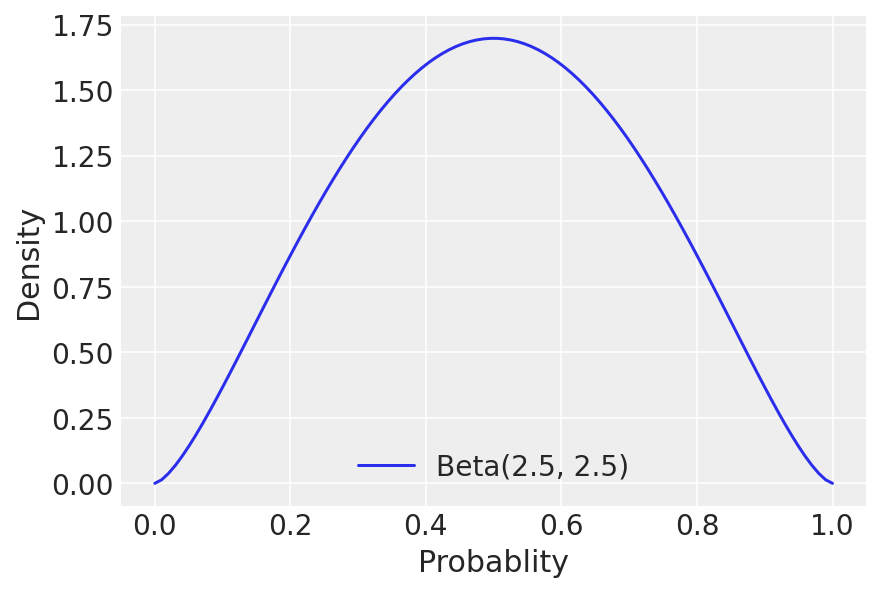

In [3]:
x_plot = np.linspace(0, 1, 100)
pbar = 0.5
theta = 5.0
plt.plot(
    x_plot,
    sp.stats.beta.pdf(x_plot[:, np.newaxis], pbar * theta, (1 - pbar) * theta),
    label=f"Beta({pbar * theta}, {(1 - pbar) * theta})",
)
plt.xlabel("Probablity")
plt.ylabel("Density")
plt.legend();

#### Code 12.2

In [4]:
admit_df = pd.read_csv("Data/UCBadmit.csv", sep=";")
N = admit_df.applications.values
gid = (admit_df["applicant.gender"] == "female").astype(int).values
admit_df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [5]:
with pm.Model() as m12_1:
    a = pm.Normal("a", 0.0, 1.5, shape=2)
    phi = pm.Exponential("phi", 1.0)

    theta = pm.Deterministic("theta", phi + 2.0)
    pbar = pm.Deterministic("pbar", pm.math.invlogit(a[gid]))

    A = pm.BetaBinomial("A", pbar * theta, (1.0 - pbar) * theta, N, observed=admit_df.admit.values)

    trace_12_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


#### Code 12.3

In [6]:
az.summary(trace_12_1, var_names=["a", "phi", "theta"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.45,0.41,-1.09,0.20,0.01,0.01,3177.81,2413.19,1.0
a[1],-0.32,0.42,-1.03,0.31,0.01,0.01,3449.37,2425.77,1.0
phi,1.04,0.77,0.00,2.01,0.01,0.01,2174.00,1560.18,1.0
theta,3.04,0.77,2.00,4.01,0.01,0.01,2174.00,1560.18,1.0


In [7]:
post_a = az.extract_dataset(trace_12_1["posterior"])["a"]
diff_a = post_a[0, :] - post_a[1, :]
az.summary({"diff_a": diff_a}, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_a,-0.13,0.58,-1.06,0.76


#### Code 12.4

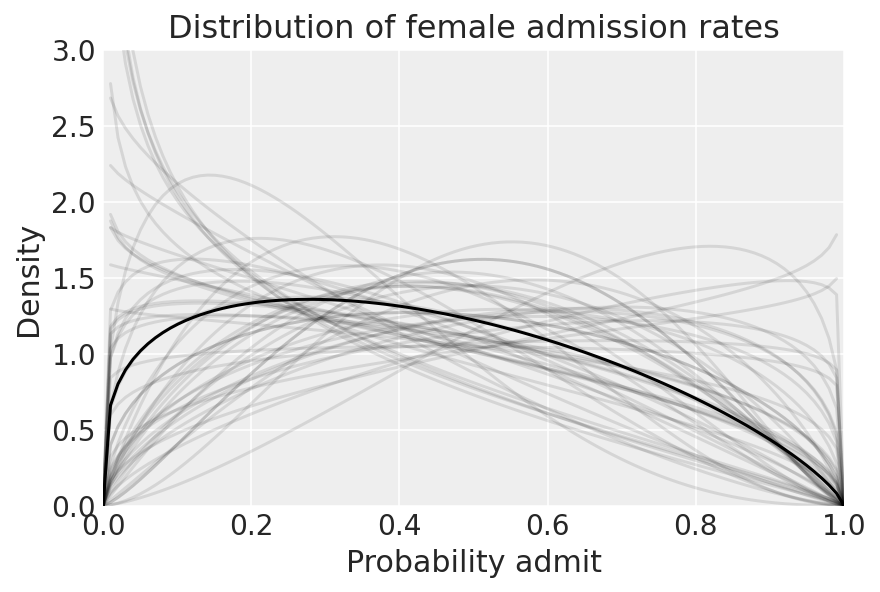

In [8]:
gid = 1
x_plot = np.linspace(0, 1, 100)
post_theta = az.extract_dataset(trace_12_1["posterior"])["theta"]

# draw posterior mean beta distribution:
pbar_mean = logistic(post_a[gid, :]).mean()
theta_mean = post_theta.mean()
plt.plot(
    x_plot,
    sp.stats.beta.pdf(x_plot, pbar_mean * theta_mean, (1.0 - pbar_mean) * theta_mean),
    c="k",
)

# draw 50 beta distributions sampled from posterior:
plt.plot(
    x_plot,
    sp.stats.beta.pdf(
        x_plot[:, np.newaxis],
        logistic(post_a[gid, :])[:50] * post_theta[:50],
        (1.0 - logistic(post_a[gid, :])[:50]) * post_theta[:50],
    ),
    c="k",
    alpha=0.1,
)

plt.xlim(0.0, 1.0)
plt.xlabel("Probability admit")
plt.ylim(0.0, 3.0)
plt.ylabel("Density")
plt.title("Distribution of female admission rates");

#### Code 12.5

In [9]:
with m12_1:
    ppc = pm.sample_posterior_predictive(trace_12_1, random_seed=RANDOM_SEED)[
        "posterior_predictive"
    ]["A"]
pp_admit = ppc / N

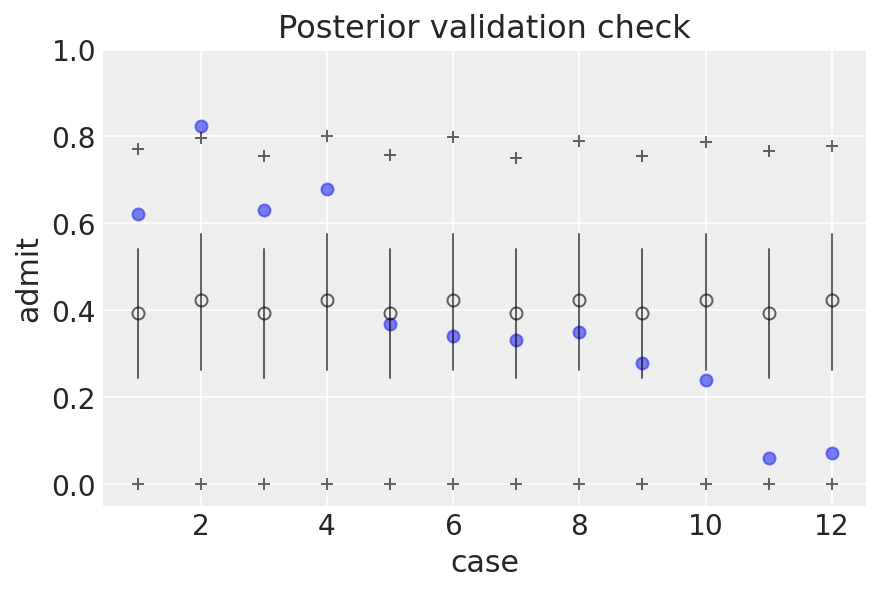

In [10]:
plt.plot(range(1, 13), admit_df.admit / N, "C0o", ms=6, alpha=0.6)
plt.plot(
    range(1, 13),
    trace_12_1["posterior"]["pbar"].mean(["chain", "draw"]),
    "ko",
    fillstyle="none",
    ms=6,
    alpha=0.6,
)
plt.plot(
    [range(1, 13), range(1, 13)],
    az.hdi(trace_12_1["posterior"]["pbar"])["pbar"].T,
    "k-",
    lw=1,
    alpha=0.6,
)
plt.plot([range(1, 13), range(1, 13)], az.hdi(pp_admit)["A"].T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-0.05, 1);

#### Code 12.6

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, g, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 55 seconds.


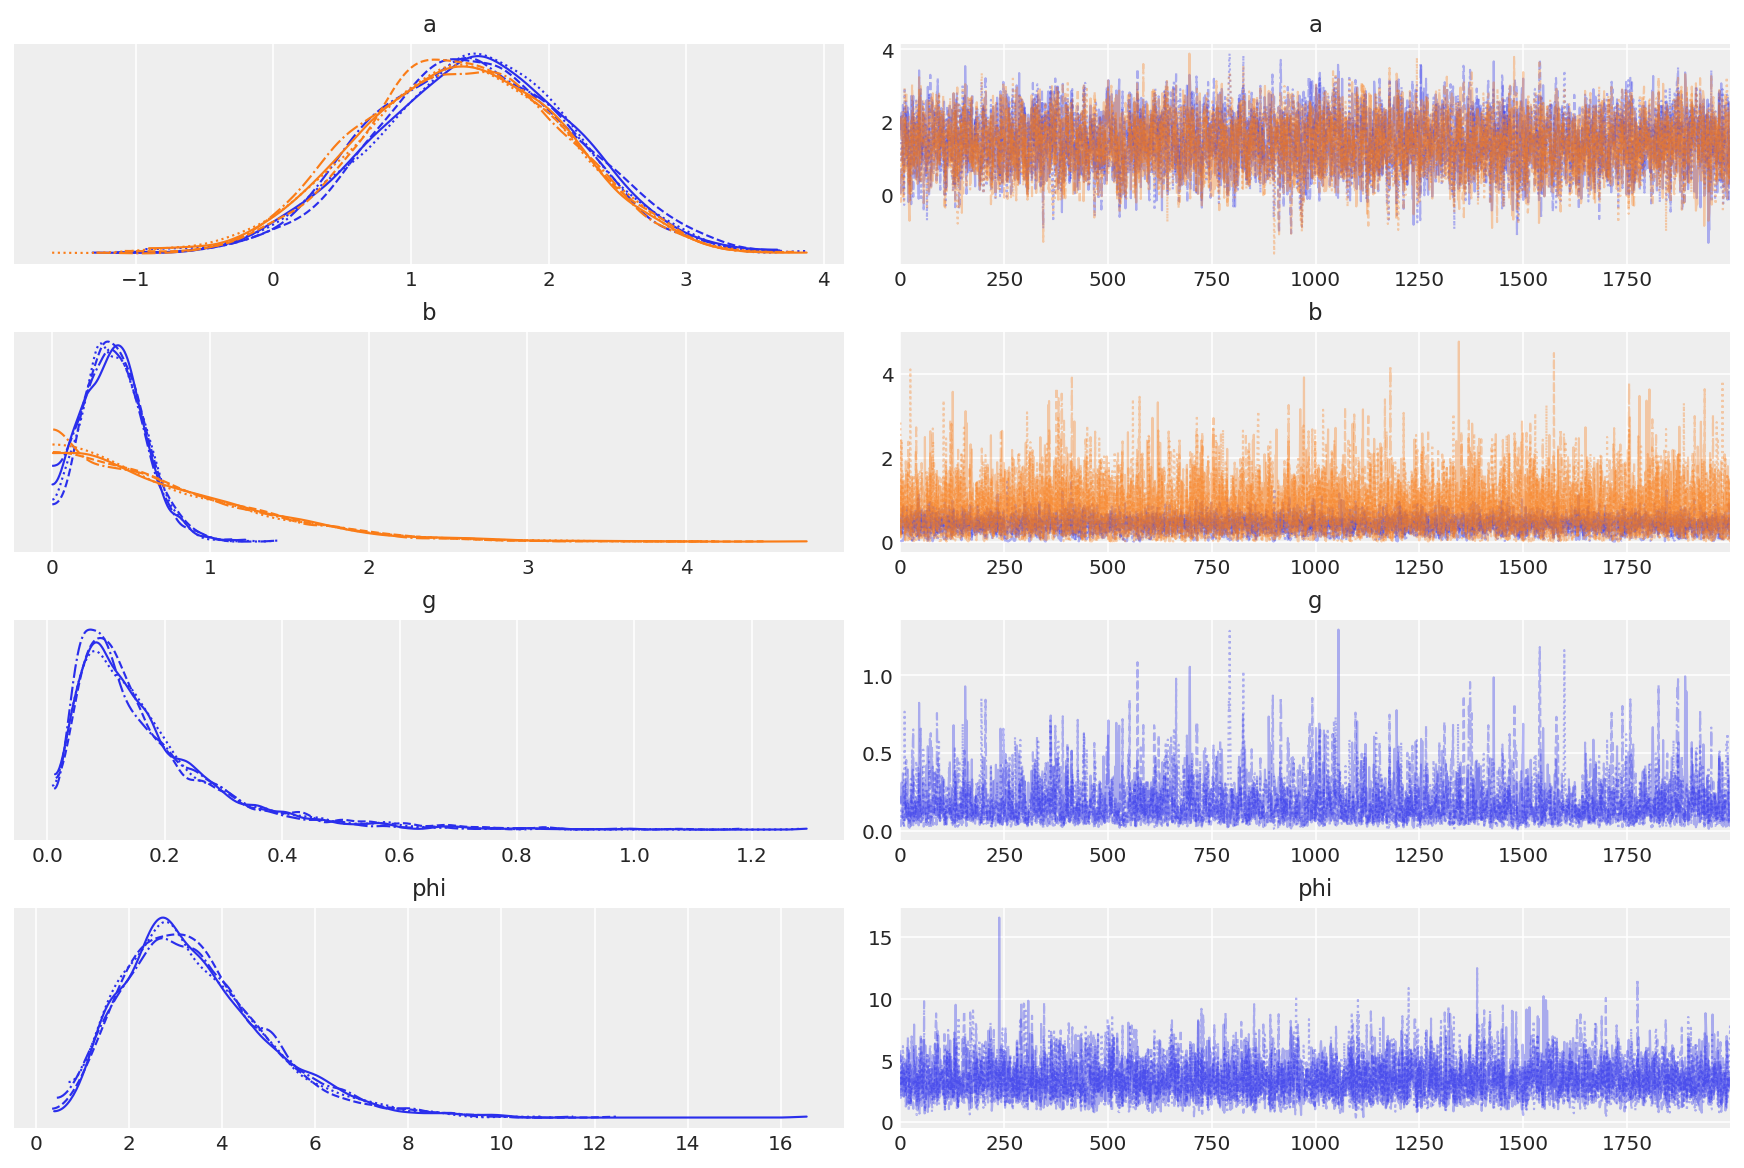

In [11]:
dk = pd.read_csv("Data/Kline", sep=";")
P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0 (see chp. 11)
c_id = (dk.contact == "high").astype(int).values

with pm.Model() as m12_2:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)
    phi = pm.Exponential("phi", 1.0)

    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", P)
    lam = (at.exp(a[cid]) * P_ ** b[cid]) / g

    T = pm.NegativeBinomial("total_tools", lam, phi, observed=dk.total_tools.values)

    trace_12_2 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_12 = az.loo(trace_12_2, pointwise=True).pareto_k.values

az.plot_trace(trace_12_2, compact=True);

#### Bonus: Figure 12.2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, g]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 68 seconds.
C:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\lib\site-packages\arviz\stats\stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


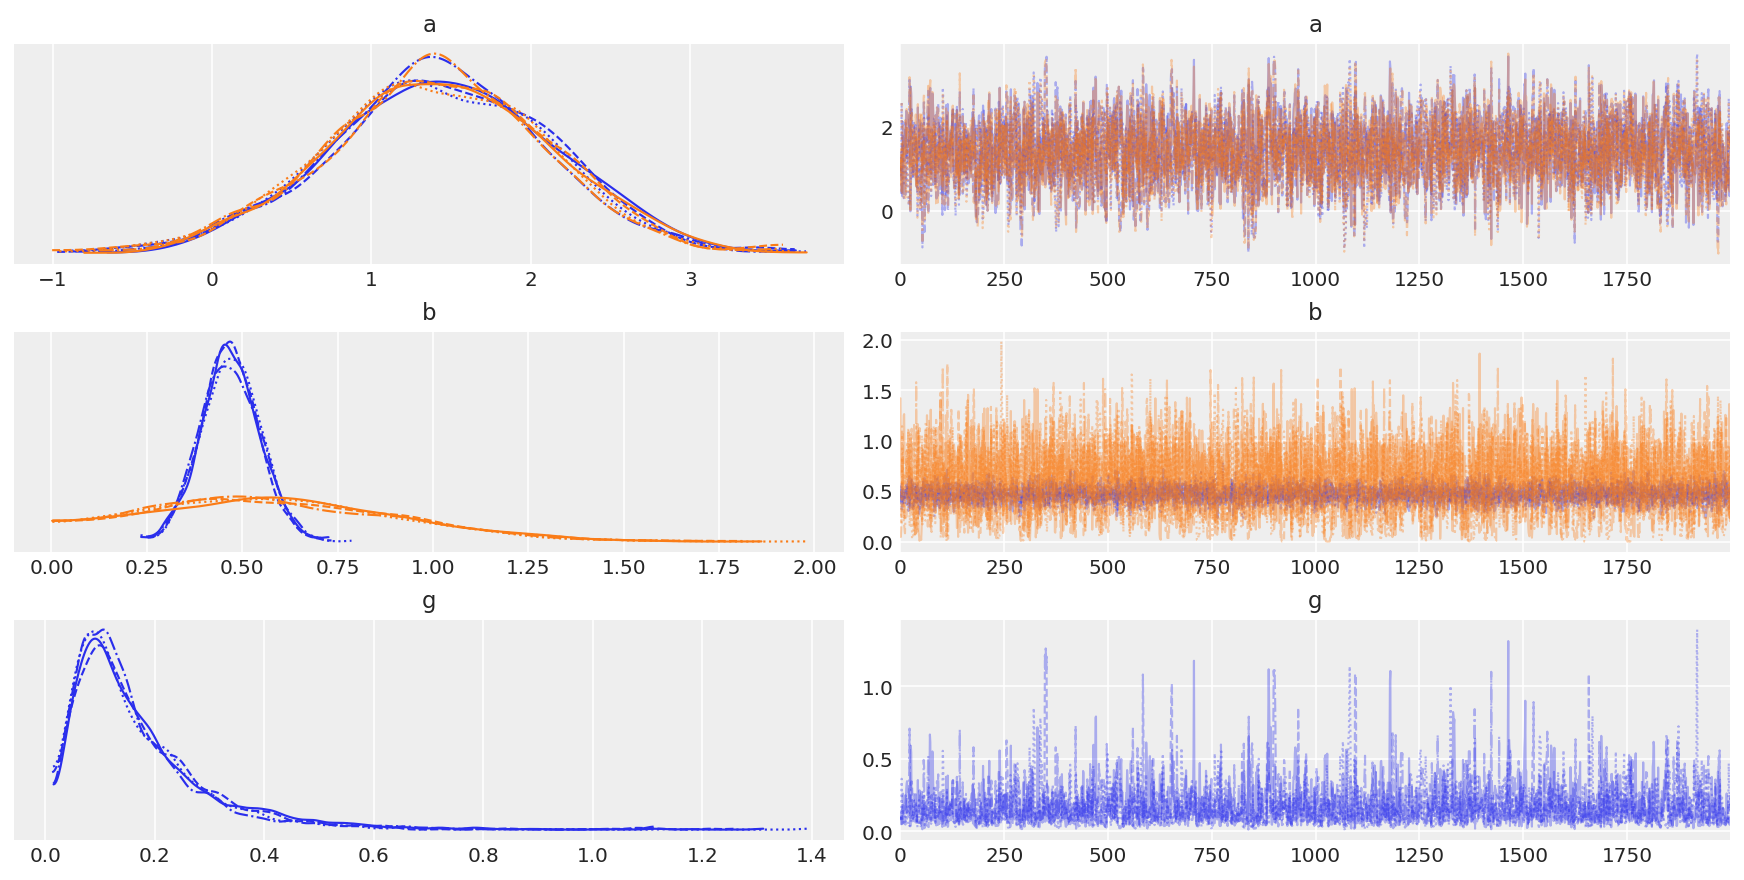

In [12]:
with pm.Model() as m11_11:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)

    cid = pm.intX(pm.Data("cid", c_id))
    P_ = pm.Data("P", P)
    lam = (at.exp(a[cid]) * P_ ** b[cid]) / g

    T = pm.Poisson("total_tools", lam, observed=dk.total_tools.values)

    trace_11_11 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_11 = az.loo(trace_11_11, pointwise=True).pareto_k.values

az.plot_trace(trace_11_11, compact=True);

In [13]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4  # our little trick

with m11_11:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0_11 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam1_11 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

with m12_2:
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0_12 = pm.sample_posterior_predictive(trace_12_2, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

    pm.set_data({"cid": np.array([1] * ns)})
    lam1_12 = pm.sample_posterior_predictive(trace_12_2, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

lmu0_11, lmu1_11 = lam0_11.mean(["chain", "draw"]), lam1_11.mean(["chain", "draw"])
lmu0_12, lmu1_12 = lam0_12.mean(["chain", "draw"]), lam1_12.mean(["chain", "draw"])

Text(0.5, 1.0, 'Gamma-Poisson model')

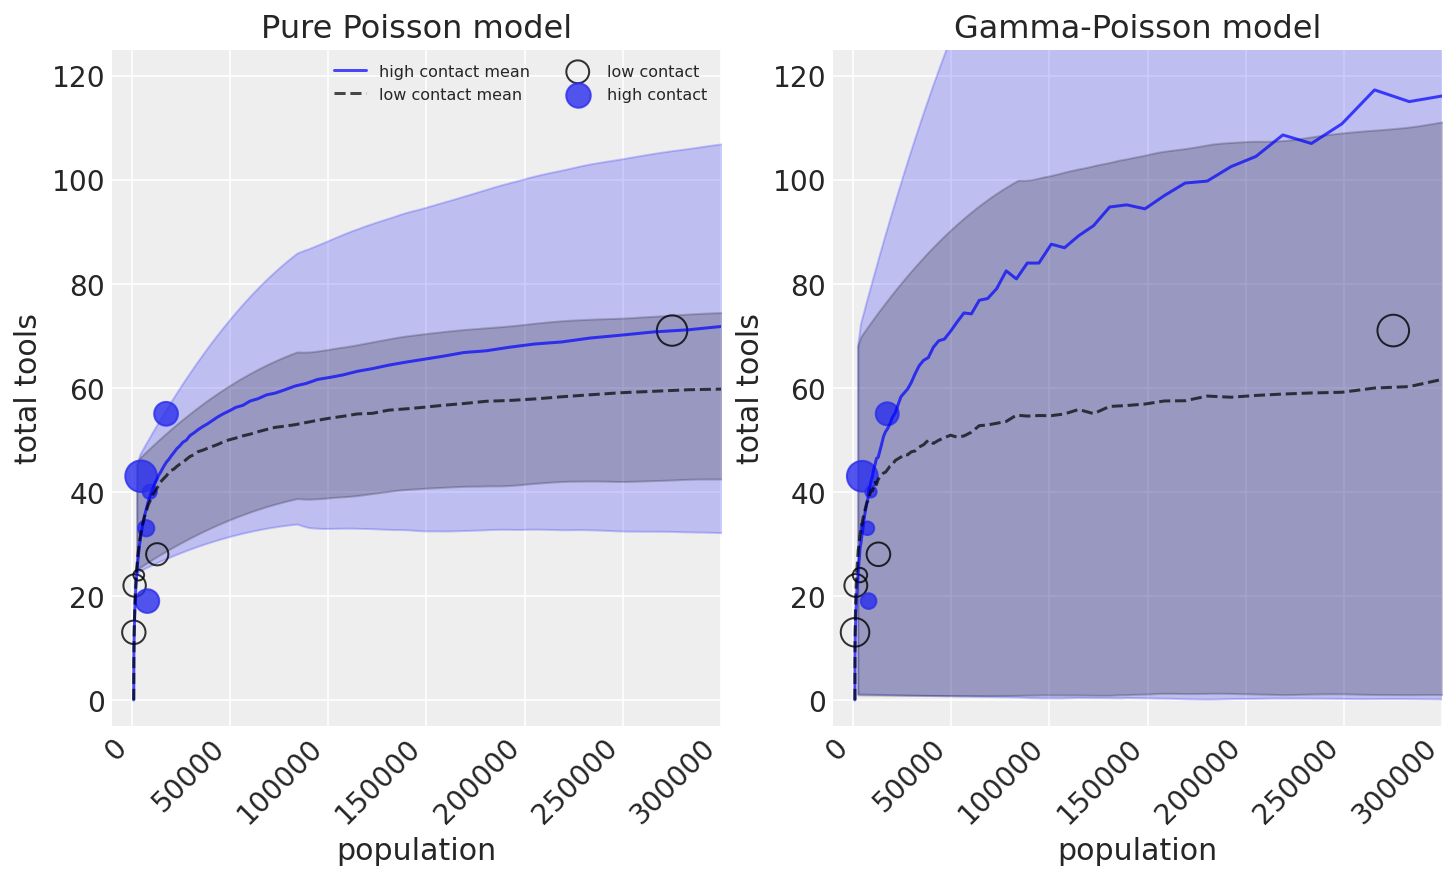

In [14]:
# scale point size to Pareto-k:
k_11 /= k_11.max()
psize_11 = 250 * k_11
k_12 /= k_12.max()
psize_12 = 250 * k_12

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))

# Poisson predictions:
# unstandardize our log pop sequence:
P_seq = np.exp(
    (P_seq - 1.4) * np.log(dk.population.values).std() + np.log(dk.population.values).mean()
)
az.plot_hdi(P_seq, lam1_11, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1_11, color="b", alpha=0.7, label="high contact mean")

az.plot_hdi(P_seq, lam0_11, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0_11, "--", color="k", alpha=0.7, label="low contact mean")

# display observed data:
index = c_id == 1
ax0.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize_11[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(
    dk.population[index], dk.total_tools[index], s=psize_11[index], alpha=0.8, label="high contact"
)
plt.setp(ax0.get_xticklabels(), ha="right", rotation=45)
ax0.set_xlim((-10_000, 300_000))
ax0.set_xlabel("population")
ax0.set_ylabel("total tools")
ax0.set_ylim((-5, 125))
ax0.set_title("Pure Poisson model")
ax0.legend(fontsize=8, ncol=2)

# Gamma-Poisson predictions:
az.plot_hdi(P_seq, lam1_12, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1_12, color="b", alpha=0.7)

az.plot_hdi(P_seq, lam0_12, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0_12, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize_12[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize_12[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 300_000))
ax1.set_xlabel("population")
ax1.set_ylim((-5, 125))
ax1.set_ylabel("total tools")
ax1.set_title("Gamma-Poisson model")

#### Code 12.7

In [15]:
# define parameters
PROB_DRINK = 0.2  # 20% of days
RATE_WORK = 1.0  # average 1 manuscript per day

# sample one year of production
N = 365

# simulate days monks drink
drink = np.random.binomial(1, PROB_DRINK, size=N)

# simulate manuscripts completed
y = (1 - drink) * np.random.poisson(RATE_WORK, size=N)

#### Code 12.8

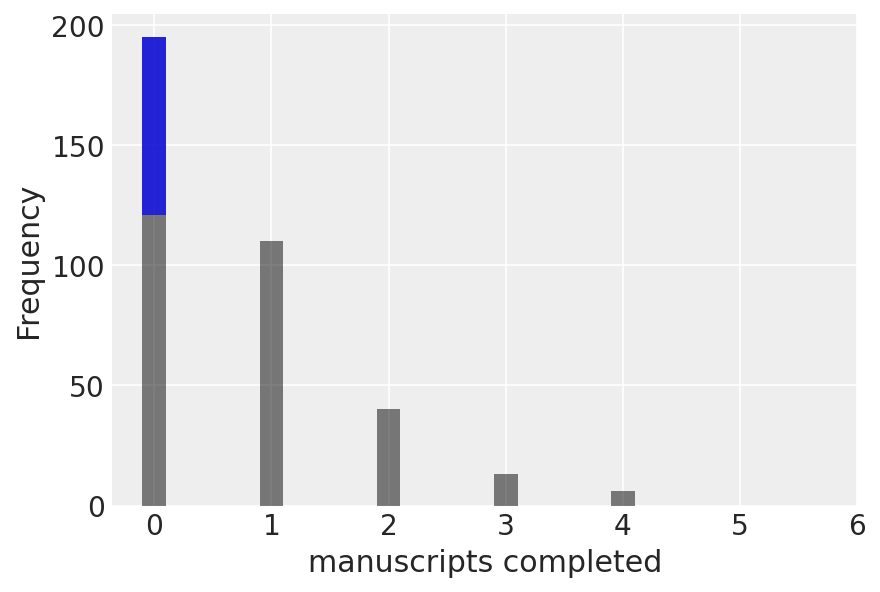

In [16]:
zeros_drink = drink.sum()
zeros_work = (y == 0).sum() - zeros_drink

bins = np.arange(y.max() + 1) - 0.5
plt.hist(y, bins=bins, align="mid", rwidth=0.2, color="k", alpha=0.5)
plt.bar(0.0, zeros_drink, bottom=zeros_work, width=0.2, color="b", alpha=0.7)

plt.xticks(bins + 0.5)
plt.xlabel("manuscripts completed")
plt.ylabel("Frequency");

#### Code 12.9

In [17]:
with pm.Model() as m12_3:
    ap = pm.Normal("ap", -1.5, 1.0)
    al = pm.Normal("al", 1.0, 0.5)

    p = pm.math.invlogit(ap)
    lambda_ = pm.math.exp(al)

    y_obs = pm.ZeroInflatedPoisson("y_obs", 1.0 - p, lambda_, observed=y)

    trace_12_3 = pm.sample(tune=2000, random_seed=RANDOM_SEED)
az.summary(trace_12_3, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ap, al]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 30 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ap,-1.33,0.43,-1.92,-0.69,0.01,0.01,982.56,1258.46,1.0
al,-0.08,0.10,-0.23,0.08,0.00,0.00,1004.97,1450.88,1.0


#### Code 12.10

In [18]:
logistic(trace_12_3["posterior"]["ap"]).mean(["chain", "draw"])  # probability drink

<xarray.DataArray 'ap' ()>
array(0.21819345)

In [19]:
np.exp(trace_12_3["posterior"]["al"]).mean(
    ["chain", "draw"]
)  # rate finish manuscripts, when not drinking

<xarray.DataArray 'al' ()>
array(0.93139626)

#### Code 12.11

Stan-related

#### Code 12.12

In [20]:
trolley_df = pd.read_csv("Data/Trolley.csv", sep=";")
trolley_df.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


#### Code 12.13

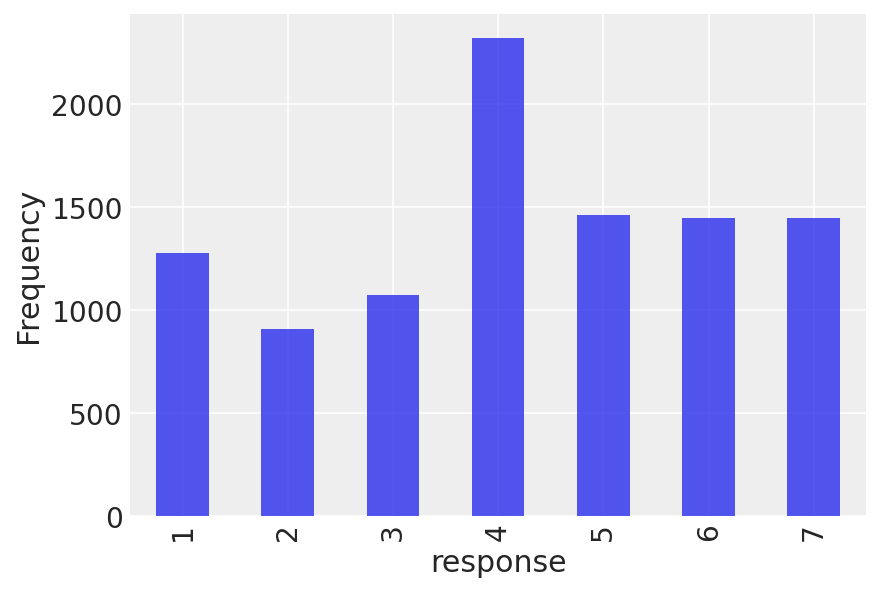

In [21]:
ax = trolley_df.response.sort_values().value_counts(sort=False).plot(kind="bar", alpha=0.8)
ax.set_xlabel("response")
ax.set_ylabel("Frequency");

#### Code 12.14

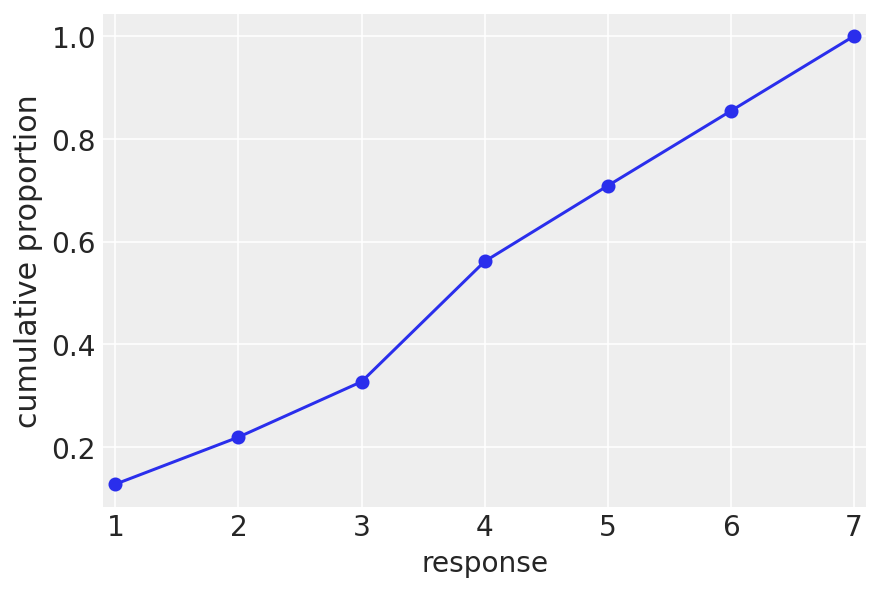

In [22]:
ax = (
    trolley_df.response.sort_values()
    .value_counts(normalize=True, sort=False)
    .cumsum()
    .plot(marker="o")
)

ax.set_xlim(0.9, 7.1)
ax.set_xlabel("response", fontsize=14)
ax.set_ylabel("cumulative proportion");

#### Code 12.15

In [23]:
lco = (
    trolley_df.response.sort_values()
    .value_counts(normalize=True, sort=False)
    .cumsum()
    .apply(sp.special.logit)
)
lco.round(2)

1   -1.92
2   -1.27
3   -0.72
4    0.25
5    0.89
6    1.77
7     NaN
Name: response, dtype: float64

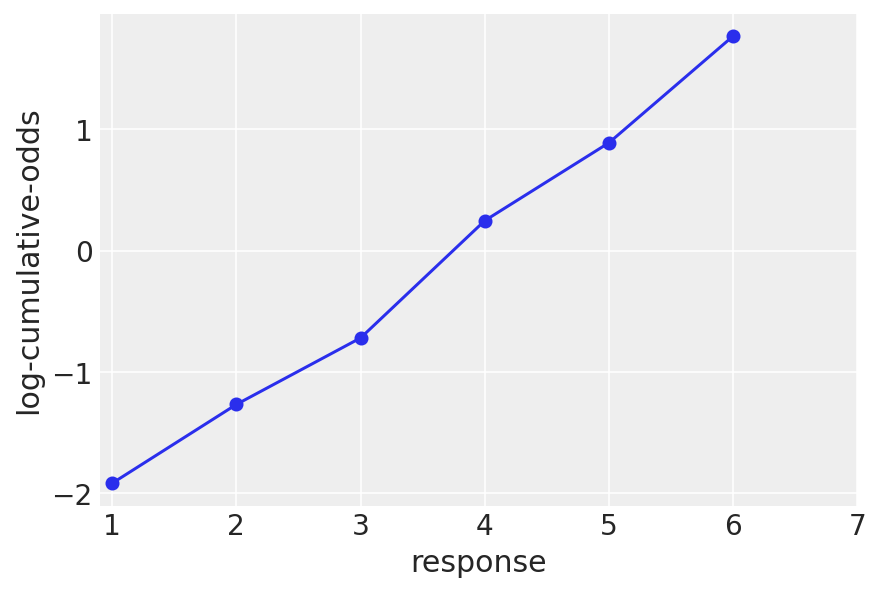

In [24]:
ax = lco.plot(marker="o")
ax.set_xlim(0.9, 7)
ax.set_xlabel("response")
ax.set_ylabel("log-cumulative-odds");

#### Code 12.16 / 17

In [25]:
with pm.Model() as m12_4:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    R = pm.OrderedLogistic("R", 0.0, cutpoints, observed=trolley_df.response.values - 1)

#### Code 12.18

In [26]:
with m12_4:
    trace_12_4 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_12_4, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-1.92,0.03,-1.97,-1.88,0.0,0.0,3996.07,2838.27,1.0
cutpoints[1],-1.27,0.02,-1.31,-1.23,0.0,0.0,4449.56,3120.31,1.0
cutpoints[2],-0.72,0.02,-0.75,-0.69,0.0,0.0,4436.63,3649.05,1.0
cutpoints[3],0.25,0.02,0.22,0.28,0.0,0.0,4583.30,3658.22,1.0
cutpoints[4],0.89,0.02,0.86,0.93,0.0,0.0,4278.27,3614.83,1.0
cutpoints[5],1.77,0.03,1.73,1.82,0.0,0.0,4530.96,3609.44,1.0
R_probs[0],0.13,0.00,0.12,0.13,0.0,0.0,3996.07,2838.27,1.0
R_probs[1],0.09,0.00,0.09,0.10,0.0,0.0,4602.98,3034.35,1.0
R_probs[2],0.11,0.00,0.10,0.11,0.0,0.0,4716.58,2858.04,1.0
R_probs[3],0.23,0.00,0.23,0.24,0.0,0.0,4969.65,3176.56,1.0


#### Code 12.19

In [27]:
logistic(trace_12_4["posterior"]["cutpoints"]).mean(["chain", "draw"]).round(3)

<xarray.DataArray 'cutpoints' (cutpoints_dim_0: 6)>
array([0.128, 0.219, 0.327, 0.562, 0.709, 0.855])
Coordinates:
  * cutpoints_dim_0  (cutpoints_dim_0) int32 0 1 2 3 4 5

#### Code 12.20

In [28]:
def ordered_logistic_proba(a):
    p_cum = logistic(a)
    p_cum = np.concatenate(([0.0], p_cum, [1.0]))

    return p_cum[1:] - p_cum[:-1]


pk = ordered_logistic_proba(trace_12_4["posterior"]["cutpoints"].mean(["chain", "draw"]))
pk.round(2)

array([0.13, 0.09, 0.11, 0.23, 0.15, 0.15, 0.15])

#### Code 12.21

In [29]:
(pk * np.arange(1, 8)).sum()

4.1999116722301295

#### Code 12.22

In [30]:
pk = ordered_logistic_proba(trace_12_4["posterior"]["cutpoints"].mean(["chain", "draw"]) - 0.5)
pk.round(2)

array([0.08, 0.06, 0.08, 0.21, 0.16, 0.18, 0.22])

#### Code 12.23

In [31]:
(pk * np.arange(1, 8)).sum()

4.72960544267553

#### Code 12.24

In [32]:
R = trolley_df.response.values - 1

with pm.Model() as m12_5:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)

    A = pm.Data("A", trolley_df.action.values)
    I = pm.Data("I", trolley_df.intention.values)
    C = pm.Data("C", trolley_df.contact.values)

    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic("phi", bA * A + bC * C + BI * I)

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=R)

    trace_12_5 = pm.sample(random_seed=RANDOM_SEED)

az.summary(trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, bA, bC, bI, bIA, bIC]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 325 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bIC,-1.23,0.10,-1.38,-1.07,0.0,0.0,2279.21,2339.96,1.0
bIA,-0.43,0.08,-0.56,-0.31,0.0,0.0,2291.51,2635.40,1.0
bC,-0.35,0.07,-0.46,-0.24,0.0,0.0,2485.21,2640.12,1.0
bI,-0.29,0.06,-0.39,-0.21,0.0,0.0,2041.12,2345.00,1.0
bA,-0.47,0.05,-0.56,-0.38,0.0,0.0,2142.89,2854.41,1.0


#### Code 12.25

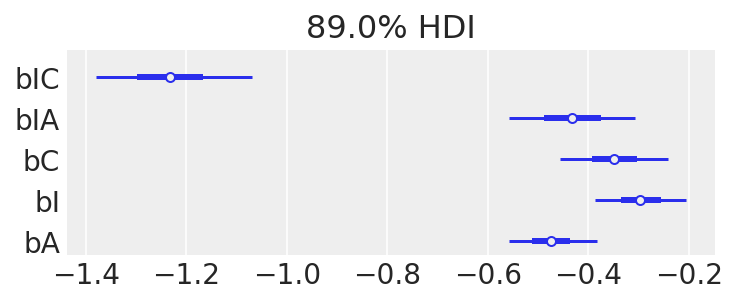

In [33]:
az.plot_forest(
    trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], figsize=(5, 2), combined=True
);

#### Code 12.26 - 28

In [34]:
# Observed cum probs:
p_obs = (
    trolley_df.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

In [35]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


In [36]:
with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(trace_12_5, var_names=["phi"], random_seed=RANDOM_SEED)[
        "posterior_predictive"
    ]

In [37]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = pd.concat([cases_df, p], axis=1).set_index(["action", "contact", "intention"]).sort_index()
    p.index.name = "case"
    p.columns.name = "response"

    return p

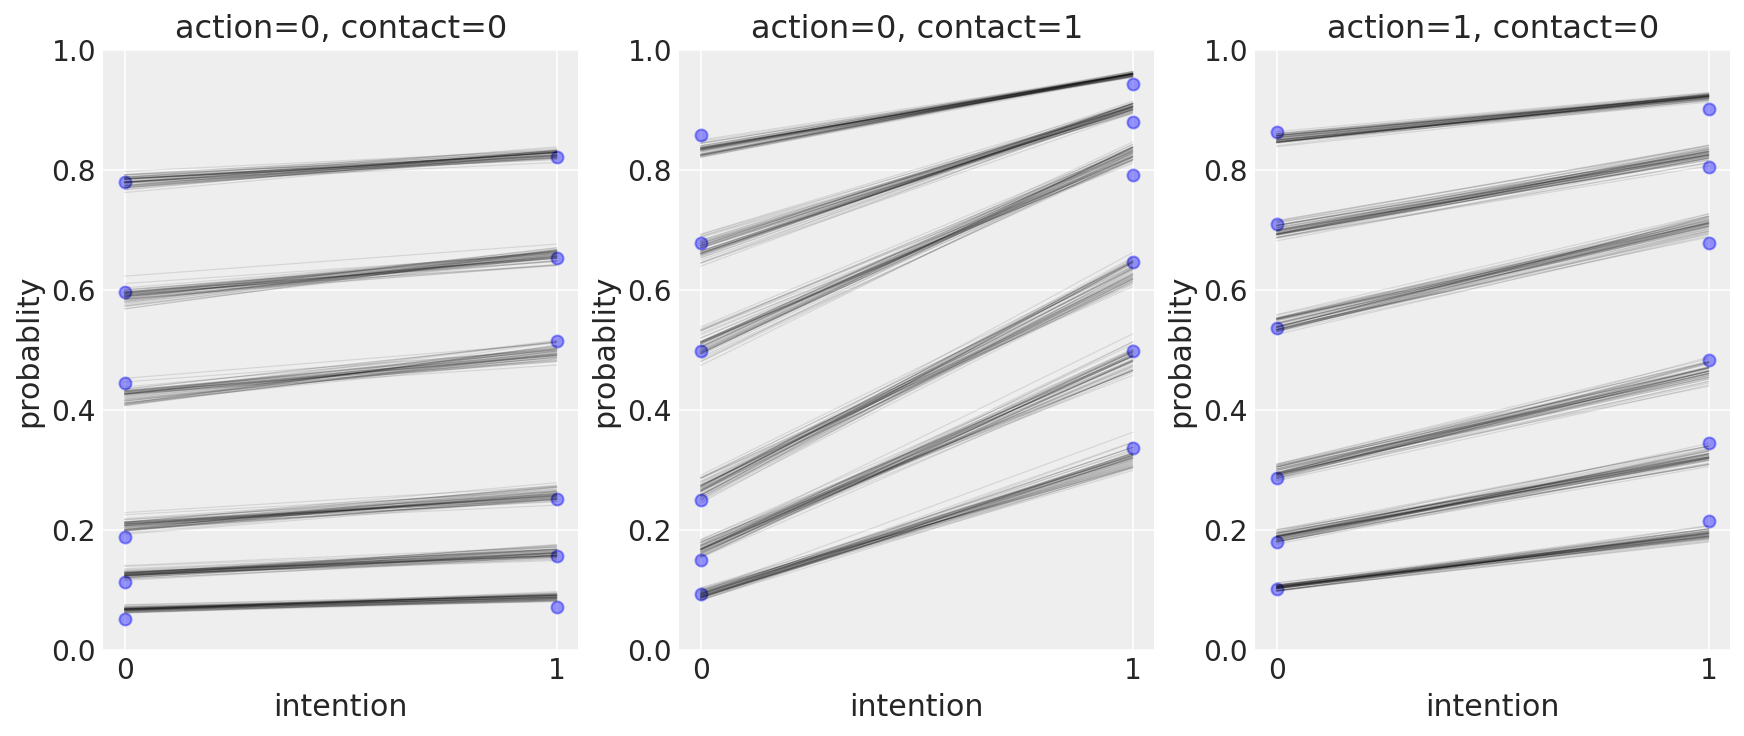

In [38]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

pp_cut_array = np.array(az.extract_dataset(trace_12_5["posterior"])["cutpoints"]).T
pp_phi_array = np.array(az.extract_dataset(pp_phi)["phi"]).T

for s in range(50):
    p = p_ord_logit(responses=range(6), phi=pp_phi_array[s], a=pp_cut_array[s])

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1

#### Code 12.29

In [39]:
with m12_5:
    pp_resp = pm.sample_posterior_predictive(
        trace_12_5, var_names=["resp_obs"], random_seed=RANDOM_SEED
    )["posterior_predictive"]
    pp_resp_array = np.array(az.extract_dataset(pp_resp)["resp_obs"])

resp_df = pd.DataFrame(pp_resp_array)
resp_df.index.name = "case"
resp_df = (
    pd.concat([cases_df, resp_df], axis=1)
    .set_index(["action", "contact", "intention"])
    .sort_index()
)
resp_df

0     1     2     3     4     5     6     7     \
action contact intention                                                   
0      0       0             4     2     3     4     1     3     2     4   
               1             6     3     2     6     6     4     5     3   
       1       0             6     5     4     5     4     5     6     3   
               1             1     6     3     3     1     5     3     2   
1      0       0             4     6     4     6     5     4     0     0   
               1             2     3     0     0     0     3     1     2   

                          8     9     ...  3990  3991  3992  3993  3994  3995  \
action contact intention              ...                                       
0      0       0             0     4  ...     3     2     3     4     2     6   
               1             6     6  ...     5     4     4     5     1     6   
       1       0             6     3  ...     3     4     3     6     3     3   
               1             4     5  ...     1     0     0     4     3     0   
1      0       0             4     2  ...     0     6     0     0     3     5   
               1             1     0  ...     3     2     4     4     3     4   

                          3996  3997  3998  3999  
action contact intention                          
0      0       0             3     6     4     4  
               1             4     1     3     2  
       1       0             6     5     2     0  
               1             4     0     0     3  
1      0       0             2     0     3     2  
               1             1     3     0     0  

[6 rows x 4000 columns]

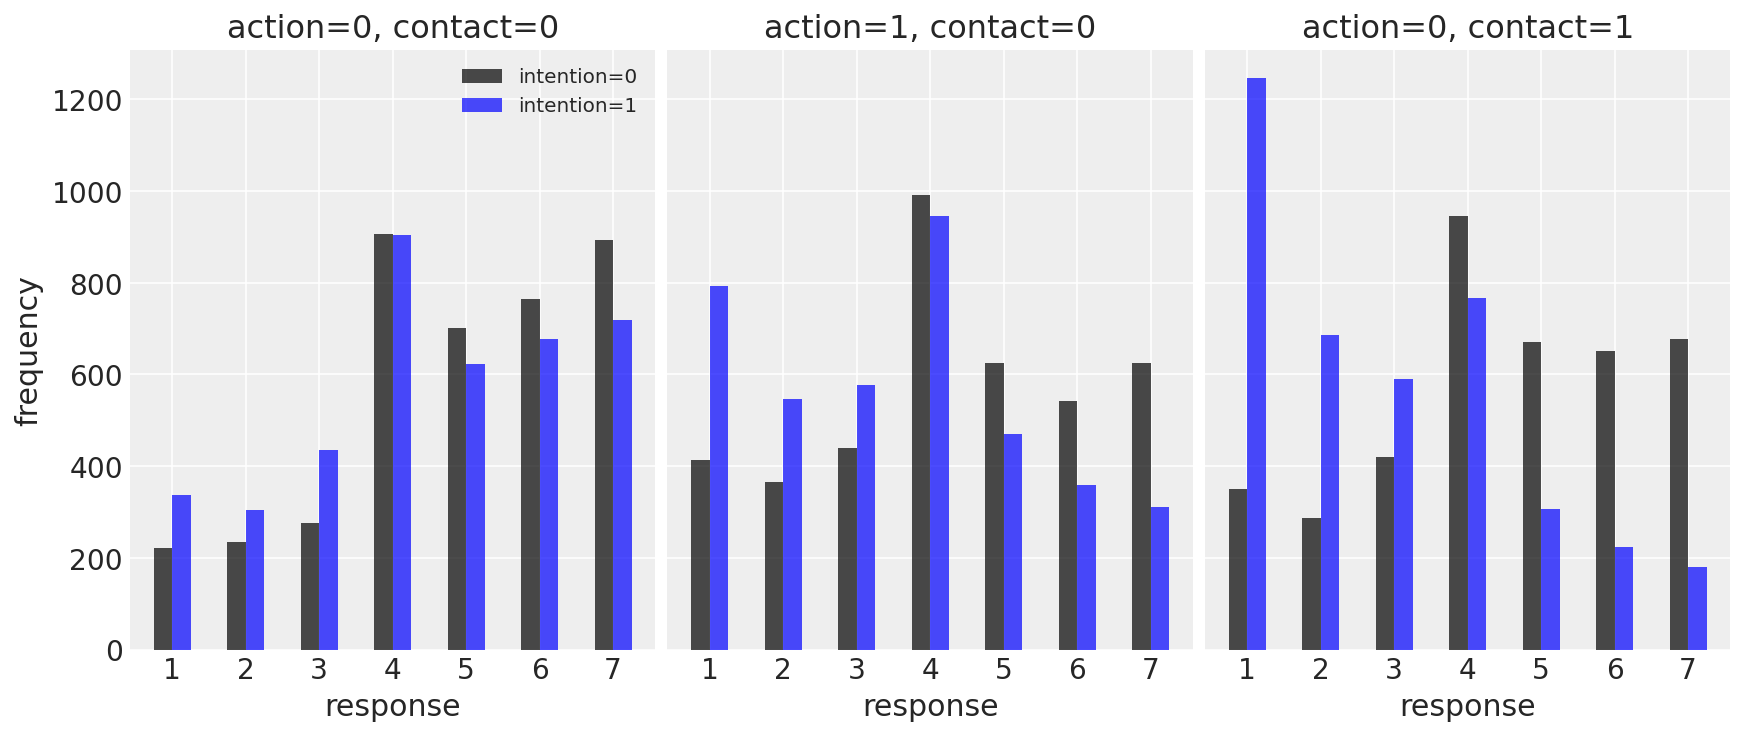

In [40]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
bins, xticks, xlabels, colors = (
    np.arange(8) - 0.5,
    np.arange(7),
    np.arange(1, 8),
    ["k", "b"],
)

axes[0].hist(
    [resp_df.loc[0, 0, 0], resp_df.loc[0, 0, 1]],
    bins=bins,
    rwidth=0.5,
    label=["intention=0", "intention=1"],
    color=colors,
    alpha=0.7,
)
axes[0].set_title("action=0, contact=0")
axes[0].set_ylabel("frequency")
axes[0].legend(fontsize=10)

axes[1].hist(
    [resp_df.loc[1, 0, 0], resp_df.loc[1, 0, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[1].set_title("action=1, contact=0")

axes[2].hist(
    [resp_df.loc[0, 1, 0], resp_df.loc[0, 1, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[2].set_title("action=0, contact=1")

for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel("response")

#### Code 12.30

In [41]:
pd.Categorical(trolley_df.edu)

['Middle School', 'Middle School', 'Middle School', 'Middle School', 'Middle School', ..., 'Graduate Degree', 'Graduate Degree', 'Graduate Degree', 'Graduate Degree', 'Graduate Degree']
Length: 9930
Categories (8, object): ['Bachelor's Degree', 'Elementary School', 'Graduate Degree', 'High School Graduate', 'Master's Degree', 'Middle School', 'Some College', 'Some High School']

#### Code 12.31

In [42]:
trolley_df["edu_new"] = pd.Categorical(
    trolley_df.edu.values,
    categories=[
        "Elementary School",
        "Middle School",
        "Some High School",
        "High School Graduate",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "Graduate Degree",
    ],
    ordered=True,
)
trolley_df["edu_new"] = trolley_df.edu_new.cat.codes

#### Code 12.32

In [43]:
delta = np.random.dirichlet(np.repeat(2.0, 7), size=10)

#### Code 12.33

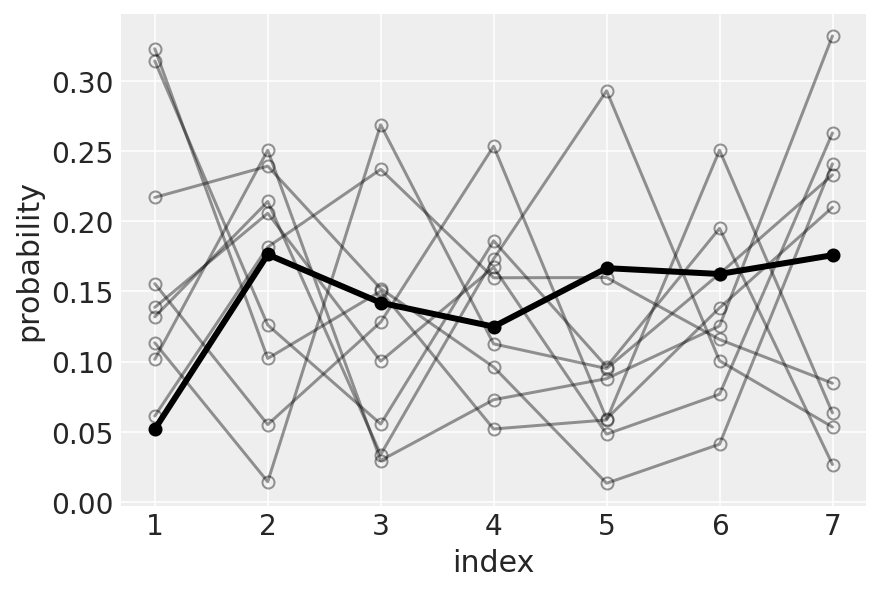

In [44]:
plt.plot(np.stack([range(1, 8)] * 9).T, delta[1:].T, "-ok", alpha=0.4, fillstyle="none")
plt.plot(np.arange(1, 8).T, delta[0].T, "-ok", lw=3, ms=6)
plt.xlabel("index")
plt.ylabel("probability");

#### Code 12.34

In [45]:
R = trolley_df.response.values - 1
A = trolley_df.action.values
I = trolley_df.intention.values
C = trolley_df.contact.values
E = trolley_df.edu_new.values

with pm.Model() as m12_6:
    kappa = pm.Normal(
        "kappa",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = at.concatenate([at.zeros(1), delta])
    delta_j_cumulative = at.cumsum(delta_j)

    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, kappa, observed=R)

    trace_12_6 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, bA, bC, bI, bE, delta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1770 seconds.


#### Code 12.35

In [46]:
az.summary(trace_12_6, var_names=["bA", "bC", "bI", "bE", "delta"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.70,0.04,-0.76,-0.63,0.0,0.0,8102.76,6265.24,1.0
bC,-0.95,0.05,-1.03,-0.87,0.0,0.0,7016.29,5730.33,1.0
bI,-0.72,0.04,-0.77,-0.66,0.0,0.0,8693.16,5556.96,1.0
bE,-0.29,0.16,-0.53,-0.04,0.0,0.0,2703.89,3302.38,1.0
delta[0],0.21,0.13,0.02,0.40,0.0,0.0,4665.44,4528.65,1.0
delta[1],0.14,0.09,0.01,0.26,0.0,0.0,7671.51,4829.84,1.0
delta[2],0.19,0.11,0.02,0.35,0.0,0.0,9329.34,4829.37,1.0
delta[3],0.17,0.10,0.02,0.31,0.0,0.0,6856.20,4569.43,1.0
delta[4],0.05,0.06,0.00,0.09,0.0,0.0,3941.73,3297.45,1.0
delta[5],0.10,0.07,0.01,0.19,0.0,0.0,5253.69,4003.92,1.0


#### Code 12.36

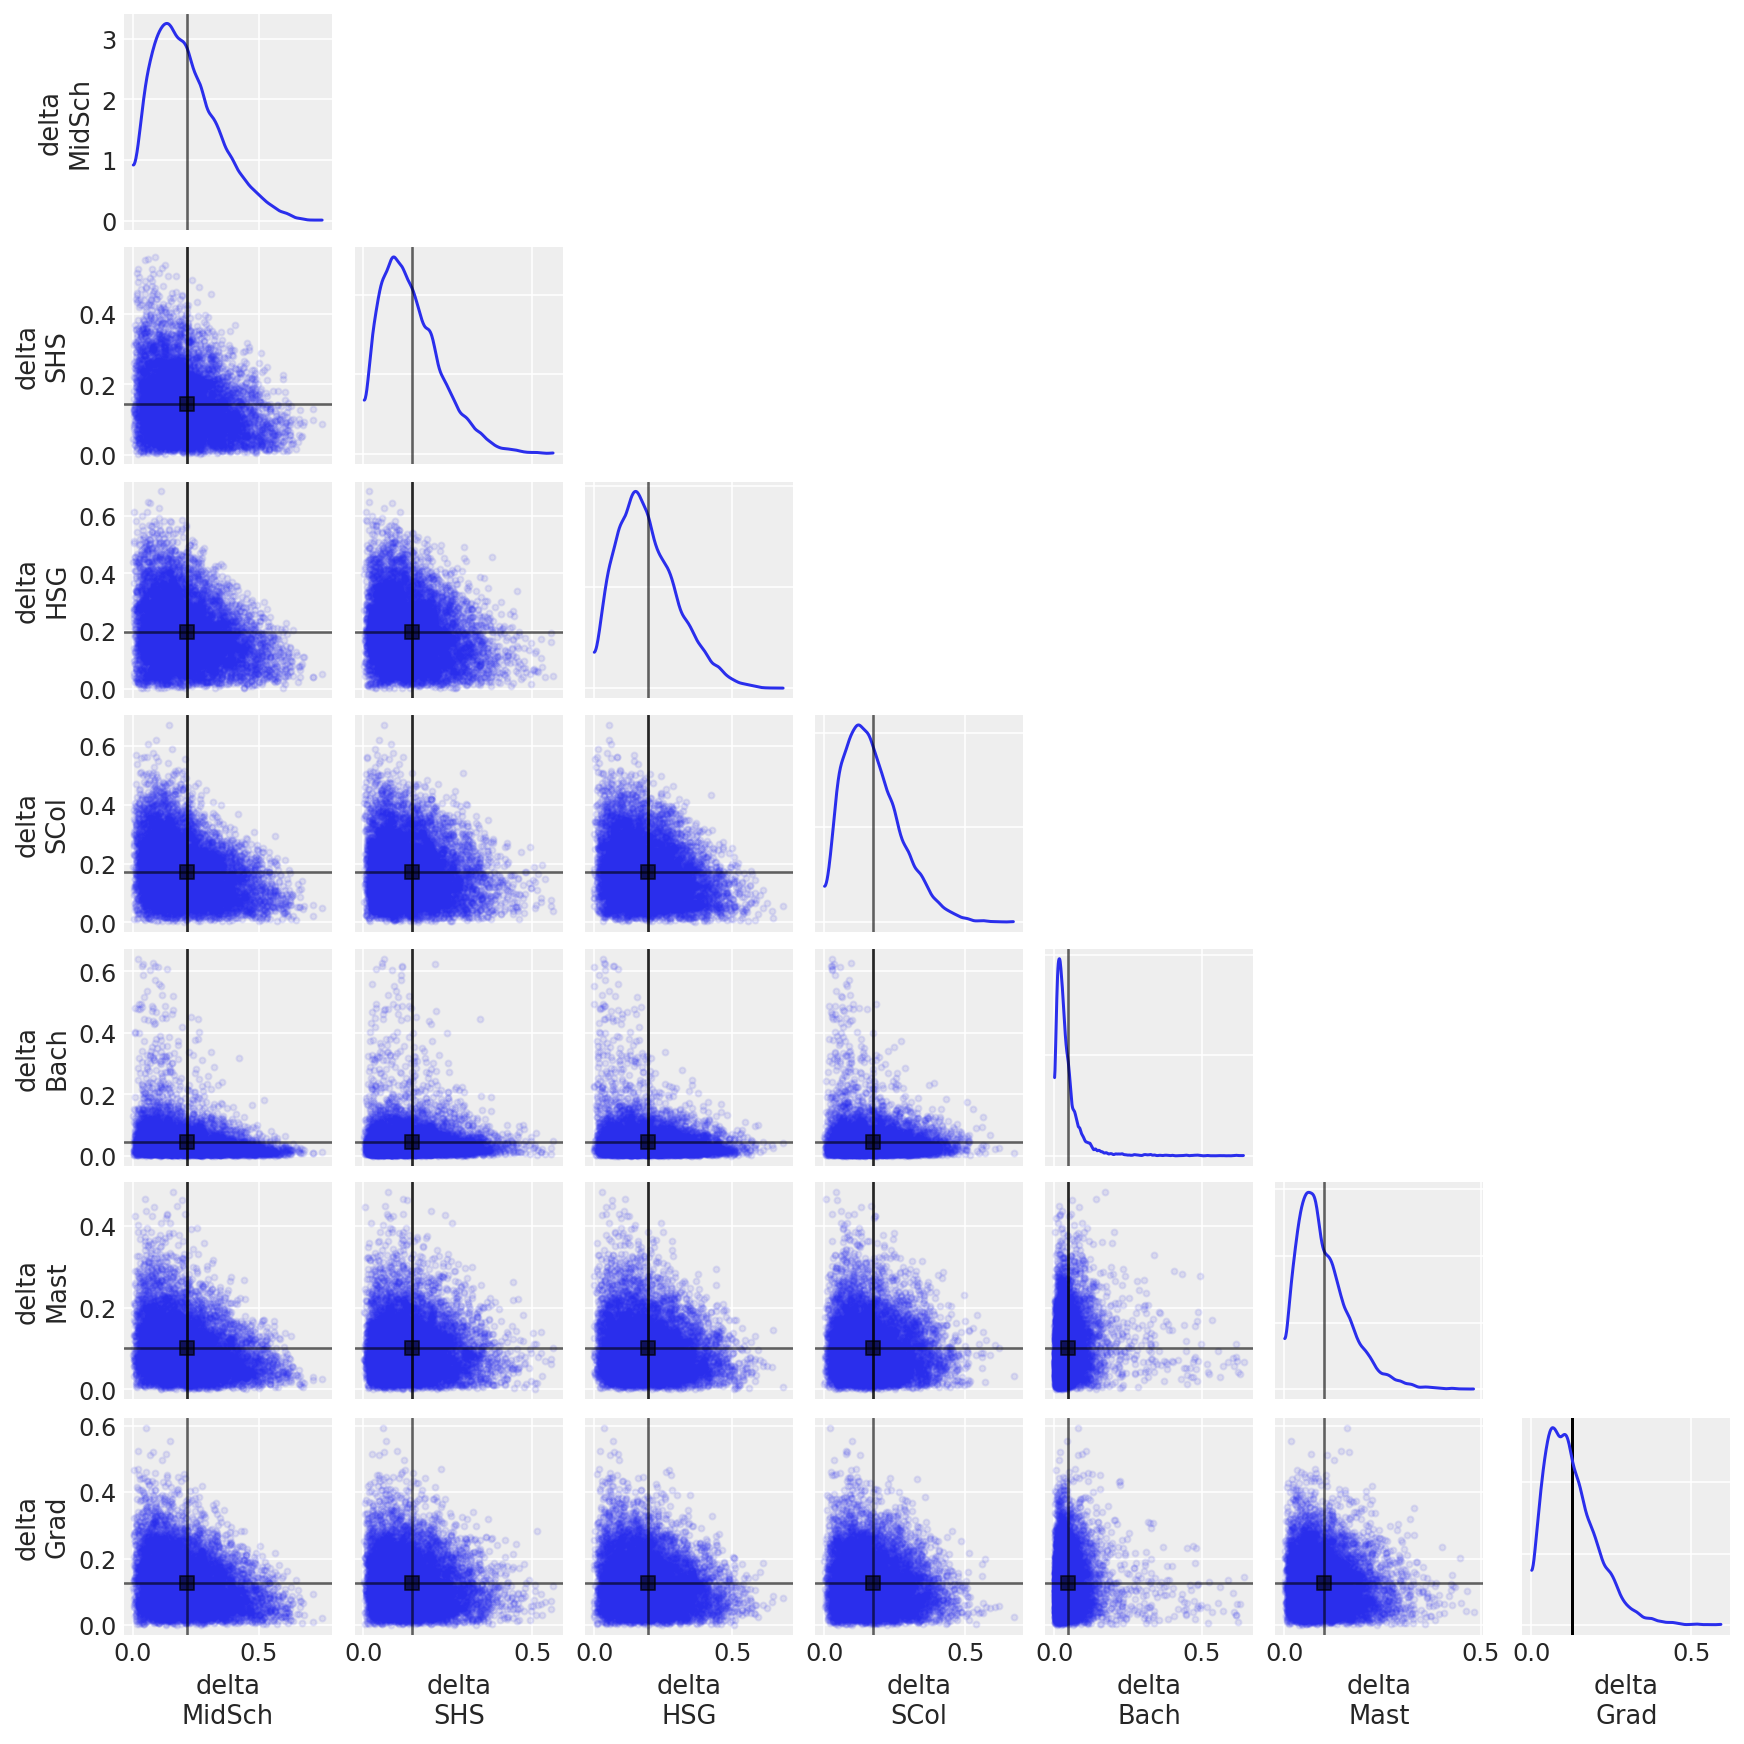

In [47]:
trace_12_6.posterior.coords["delta_dim_0"] = [
    "MidSch",
    "SHS",
    "HSG",
    "SCol",
    "Bach",
    "Mast",
    "Grad",
]

az.plot_pair(
    trace_12_6,
    var_names=["delta"],
    marginals=True,
    point_estimate="mean",
    textsize=12,
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.1},
    point_estimate_kwargs={"alpha": 0.6, "lw": 1.3},
    point_estimate_marker_kwargs={"alpha": 0.6},
);

#### Code 12.37

In [48]:
edu_norm = (
    (trolley_df.edu_new - trolley_df.edu_new.min())
    / (trolley_df.edu_new.max() - trolley_df.edu_new.min())
).values

with pm.Model() as m12_7:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    phi = bE * edu_norm + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=R)

    trace_12_7 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_12_7, var_names=["bA", "bC", "bI", "bE"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, bA, bC, bI, bE]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 411 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.70,0.04,-0.77,-0.64,0.0,0.0,3987.58,3147.06,1.0
bC,-0.95,0.05,-1.03,-0.87,0.0,0.0,4005.63,3292.93,1.0
bI,-0.72,0.04,-0.77,-0.66,0.0,0.0,4443.75,2855.88,1.0
bE,-0.10,0.09,-0.23,0.05,0.0,0.0,4592.98,2697.49,1.0


In [49]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Sep 24 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

arviz     : 0.12.1
aesara    : 2.6.6
scipy     : 1.7.3
numpy     : 1.22.1
matplotlib: 3.5.2
pandas    : 1.4.2
pymc      : 4.0.0

Watermark: 2.3.1

